In [4]:
# ------------------------------------------------- #
#  
#  ANALYSIS SCRIPT TO PROCESS DATA FROM QUANTUM COMPUTING LOHSCHMIDT ECHO
#  Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
#  arXiv:2210.03089
#
# Copyright 2023 Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), 
# to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
# and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS 
# IN THE SOFTWARE.
# 
# ------------------------------------------------- #

import sys
import os,csv
import numpy as np
np.set_printoptions(precision=4)
import pickle
import matplotlib.ticker as ticker
import math
import scipy
from scipy.stats import unitary_group
from qiskit import *
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
%matplotlib inline

import INCLUDE.basic
import INCLUDE
from INCLUDE.basis_transformations import Bogoliubov_staggered_mom_to_particle_antiparticle
from INCLUDE.basis_transformations import SFFFT_mom_to_pos
from INCLUDE.basis_transformations import quench_gate
from INCLUDE.physics import dispersion
from INCLUDE.interactions import compute_couplings
from INCLUDE.interactions import interaction_part_controlled
from INCLUDE.interactions import interaction_part

# use this for AER simulator
from qiskit.providers.aer import QasmSimulator
# use this for IONQ simulator and devices
# from qiskit_ionq import IonQProvider
# use this for IONQ simulator and devices via Microsoft Azure
# from azure.quantum.qiskit import AzureQuantumProvider

In [5]:
# ------------------------------------------------- #
#  Parameters
# ------------------------------------------------- #
N = 4            # lattice sites
m = 0.9          # mass
n_shots = 1000   # shots
T = [2.8]           # list of all times data is produced for
RunName = "your_run_name" # optional give a custom run name

# ------------------------------------------------- #
#  Coupling
# ------------------------------------------------- #
e_coupling=0.9

# ------------------------------------------------- #
#  BACKEND
# ------------------------------------------------- #
run_backend = 'AER'       # choose AER, or your backend

# ------------------------------------------------- #
#  PROVIDER
# ------------------------------------------------- #
my_provider='NONE'       # your provider

In [6]:
# -------------------------------------------------- #
#  AER SIMULATOR 
# -------------------------------------------------- #
if run_backend=='AER':
    my_backend = BasicAer.get_backend('qasm_simulator')
    
# -------------------------------------------------- #
#  OTHER PROVIDERS
# -------------------------------------------------- #
# elif run_backend=='XXX':
#     if my_provider == 'YYY':
#         # choose hardware or simulator here
            
print("# analyzing data from",my_backend)

# analyzing data from qasm_simulator


In [7]:
# ------------------------------------------------------------------------------ #
#  DATA INPUT
# ------------------------------------------------------------------------------ #
folder_load = np.zeros(len(T),object)

for i_t in range(len(T)):
    folder_load[i_t]='output_folder'
    
    print("# loading from folder",folder_load[i_t])

# loading from folder output_folder


In [8]:
# -------------------------------------------------- #
#  READING CIRCUITS AND JOB LIST 
# -------------------------------------------------- #
rec_job_list = np.zeros((len(T),2),object)
rec_transpiled = np.zeros((len(T),2),object)
rec_circuit = np.zeros((len(T),2),object)

for i_t in range(len(T)):
    
    with open(folder_load[i_t]+'/job_list') as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    
    rec_job_list[i_t][0]=lines[0]
    rec_job_list[i_t][1]=lines[1]
    
    for z_part in ["R","I"]:
        if z_part=="R":
            i_z=0
        elif z_part=="I":
            i_z=1
            
        filename_circuit=folder_load[i_t]+'/circuit_'+str(z_part)+'_id-'+str(rec_job_list[i_t][i_z])
        file_circuit = open(filename_circuit, 'rb') 
        rec_circuit[i_t][i_z] =  pickle.load(file_circuit)
        file_circuit.close()

#         if run_backend=='XXX':
#             # load transpiled cirucits
            
    print("# recovering results for t=",T[i_t])
    
# -------------------------------------------------- #
#  READING DATA 
# -------------------------------------------------- #
all_counts = np.zeros((len(T),2),object)

# if run_backend=='XXXX':
#     retrieved = np.zeros((len(T),2),object)
#     my_indices = np.arange(N+1).tolist()

#     for i_t in range(len(T)):
#         print("# i_t=",i_t,"/",len(T)-1,"with",len(rec_job_list[i_t]),"jobs")

#         for i_z in range(2):
#             retrieved[i_t][i_z] = my_backend.retrieve_job(rec_job_list[i_t][i_z])
   
            
if run_backend=='AER':
    print("# AER simulator results loaded locally")
    
    for i_t in range(len(T)):
        print("# i_t=",i_t,"/",len(T)-1,"with",len(rec_job_list[i_t]),"jobs")
    
        for i_z in range(2):
            if i_z==0:
                z_part="R"
            elif i_z==1:
                z_part="I"
            
            filename_result=folder_load+'/result_'+str(z_part)+'_id-'+rec_job_list[i_t][i_z]
            
            print("# ",z_part,filename_result[0])
            
            file_result = open(filename_result[0], 'rb') 
            result=pickle.load(file_result)
            file_result.close()

            all_counts[i_t][i_z] = result.get_counts()
            print("#", all_counts[i_t][i_z])
    
print("# results recovered.")

# recovering results for t= 2.8
# AER simulator results loaded locally
# i_t= 0 / 0 with 2 jobs
#  R output_folder/result_R_id-4d71940d-9579-4079-96ca-41f0c08b2362
# {'11000': 185, '10101': 39, '10100': 214, '10010': 173, '00110': 191, '01100': 177, '00111': 5, '01101': 8, '11001': 5, '10011': 3}
#  I output_folder/result_I_id-340b3b21-319d-473c-8c09-bc82905653bb
# {'10101': 180, '10010': 113, '00110': 133, '10100': 63, '11001': 61, '11000': 134, '00111': 58, '01100': 138, '10011': 59, '01101': 61}
# results recovered.


In [9]:
# ------------------------------------------------------------------------ #
# Compute correlation functions + Symmetry error mitigation
# ------------------------------------------------------------------------ #

def to_binary(s,N):
    return format(s, '0'+str(N)+'b')

def allowed_results(my_NN):

    sum_allowed_half=0
    sum_allowed_pairs=0
    allowed_half=[]
    allowed_pairs=[]
    
    for s in range(2**my_NN):
        sum_occ = 0
        my_occ = np.zeros(my_NN,int)

        for i in range(my_NN):
            i_occ = (s>>i)&1
            sum_occ += i_occ
            my_occ[i] = i_occ

        if sum_occ == my_NN//2:
            allowed_half.append(to_binary(s,my_NN))
            sum_allowed_half +=1 

        temp=np.zeros(my_NN//2,int)
        for j in range(my_NN//2):
            if my_occ[2*j] == my_occ[2*j+1]:
                temp[j]=True
            else:
                temp[j]=False

        allowed=True
        for j in range(len(temp)):
            if temp[j]==False:
                allowed=False
                
        if allowed==True:
            allowed_pairs.append(to_binary(s,my_NN))
            sum_allowed_pairs+=1
             
    return allowed_pairs,allowed_half,sum_allowed_pairs,sum_allowed_half

allowed_pairs,allowed_half,sum_allowed_pairs,sum_allowed_half=allowed_results(N)
        
# print("# physical states half filling",sum_allowed_half,allowed_half) 
# print("# physical states pairs",sum_allowed_pairs,allowed_pairs) 

def detect_symmetry_errors(my_counts,my_N,my_e):
    
    measurements = np.zeros(2**(2+1),float)

    my_prob_ones,my_prob_zeros = 0.0,0.0
    my_prob_ones_corrected,my_prob_zeros_corrected = 0.0,0.0
    
    my_physical_events,my_total_events = 0, 0
    
    physical_keys=[]

    for key in my_counts:
        
        is_physical=True
        
        # measure ancilla
        # NOTE string is read from right to left
        if key[my_N]=='0':
            my_prob_zeros+=my_counts[key] 
        elif key[my_N]=='1':
             my_prob_ones+=my_counts[key]
        
        my_total_events+=my_counts[key] 
                
        # measure the rest
        system_qubits = key[:my_N]

        if my_e==0:
            if system_qubits in allowed_pairs:
                is_physical=True
            else:
                is_physical=False
        elif my_e>0.0:
            if system_qubits in allowed_half:
                is_physical=True
            else:
                is_physical=False
        else:
            sys.exit("# something wrong with coupling")
        
        # only include corrected results
        if is_physical==True:
            my_physical_events += my_counts[key] 
            physical_keys.append(key)
            if key[my_N]=='0':
                my_prob_zeros_corrected+=my_counts[key] 
            elif key[my_N]=='1':
                my_prob_ones_corrected+=my_counts[key]
                
    corrected_counts = dict.fromkeys(physical_keys)
    
    for key in my_counts:
        
        system_qubits = key[:2]
        
        if my_e==0.0:
            if system_qubits in allowed_pairs:
                is_physical=True
            else:
                is_physical=False
        elif my_e>0.0:
            if system_qubits in allowed_half:
                is_physical=True
            else:
                is_physical=False
        else:
            sys.exit("# something wrong with coupling (2)")
            
        if is_physical==True:
            corrected_counts[key] = my_counts[key] 
    
    my_prob_zeros_corrected = my_prob_zeros_corrected / my_physical_events
    my_prob_ones_corrected = my_prob_ones_corrected / my_physical_events
    
    my_prob_zeros = my_prob_zeros / my_total_events
    my_prob_ones = my_prob_ones / my_total_events
        
    return my_prob_ones_corrected,my_prob_zeros_corrected,my_prob_ones,my_prob_zeros,my_physical_events,my_total_events,corrected_counts
 

In [10]:
# ------------------------------------------------------------------------ #
# Compute Lohschmidt echo and rate function
# ------------------------------------------------------------------------ #
def compute_loschmidt(my_data,my_N,my_e):
    
    loschmidt = np.zeros(len(T),complex)
    loschmidt_raw = np.zeros(len(T),complex)
    ratef = np.zeros(len(T),complex)
    ratef_raw = np.zeros(len(T),complex)
    total_counts_R,total_counts_I = np.zeros(len(T),int),np.zeros(len(T),int)
    phys_counts_R,phys_counts_I = np.zeros(len(T),int),np.zeros(len(T),int)
    
    
    if my_e>0.0:
        print("# finite coupling")
    
    for i_t in range(len(T)):
            
        p_ones_c_R,p_zeros_c_R, p_ones_R,p_zeros_R, Nphys_R, Ntotal_R, corr_res_R = detect_symmetry_errors(my_data[i_t][0],my_N,my_e)
        p_ones_c_I,p_zeros_c_I, p_ones_I,p_zeros_I, Nphys_I, Ntotal_I, corr_res_I = detect_symmetry_errors(my_data[i_t][1],my_N,my_e)

        resR = p_zeros_c_R - p_ones_c_R
        resI = p_zeros_c_I - p_ones_c_I

        loschmidt[i_t] = resR + 1.j*resI
        ratef[i_t] = -np.log(np.abs(loschmidt[i_t]))/my_N

        resR_raw = p_zeros_R - p_ones_R
        resI_raw = p_zeros_I - p_ones_I

        loschmidt_raw[i_t] = resR_raw + 1.j*resI_raw
        ratef_raw[i_t] = -np.log(np.abs(loschmidt_raw[i_t]))/my_N
        
        total_counts_R[i_t] = Ntotal_R
        total_counts_I[i_t] = Ntotal_I
        phys_counts_R[i_t] = Nphys_R
        phys_counts_I[i_t] = Nphys_I


    return loschmidt,loschmidt_raw,ratef,ratef_raw,phys_counts_R,phys_counts_I,total_counts_R,total_counts_I

In [11]:
# ------------------------------------------------------------------------ #
# Compute Lohschmidt echo and rate function
# ------------------------------------------------------------------------ #
Lt,Lt_raw,ratef,ratef_raw,phys_counts_R,phys_counts_I,total_counts_R,total_counts_I=compute_loschmidt(all_counts,N,e_coupling)

# OPTIONAL: if time evolution in interacting theory is simulated, it is implemented up to a global phase
# in this case can multiply by that phase to get Loschmidt echo correctly, otherwise onlly the absolute value is correct
# def my_phase(T):       
#     if e_coupling>0.0:
#         factor= INSERT HERE 
#     return np.exp(-1.j*factor*T)
#Lt_phase = np.zeros(len(Lt),complex)
#for i_t in range(len(Lt)):
#    Lt[i_t] = my_phase(T[i_t])*Lt[i_t]
#   Lt_raw[i_t] = my_phase(T[i_t])*Lt_raw[i_t]

folder_save = 'combined_output_folder'

if not os.path.exists(folder_save):
    os.makedirs(folder_save)
    
print("# writing to ",folder_save)

with open(folder_save+'/Lt.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(T,np.real(Lt),np.imag(Lt),np.real(ratef),phys_counts_R,phys_counts_I))
                     
with open(folder_save+'/Lt_raw.csv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(T,np.real(Lt_raw),np.imag(Lt_raw),np.real(ratef_raw),total_counts_R,total_counts_I))
    
    

# finite coupling
# writing to  combined_output_folder


Text(0, 0.5, '\\textbf{Rate function} $\\Gamma(t)$')

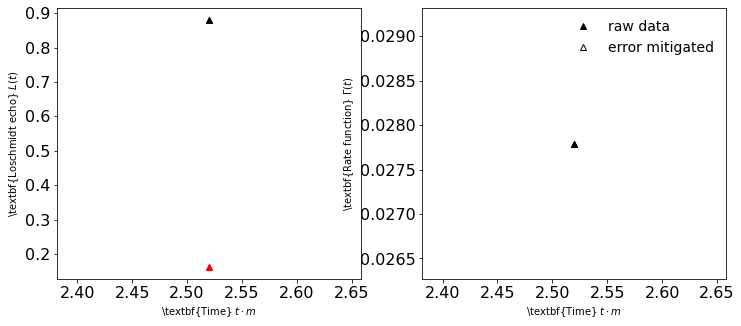

In [12]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,5))
ax1,ax2=plt.subplot(121),plt.subplot(122)

ax1.plot(m*np.array(T),np.real(Lt_raw),color='k',marker='^',linestyle='None')
ax1.plot(m*np.array(T),np.imag(Lt_raw),color='r',marker='^',linestyle='None')
ax1.plot(m*np.array(T),np.real(Lt),color='k',marker='^',linestyle='None',mfc='None')
ax1.plot(m*np.array(T),np.imag(Lt),color='r',marker='^',linestyle='None',mfc='None')

ax2.plot(m*np.array(T),np.real(ratef_raw),color='k',marker='^',linestyle='None',label='raw data')
ax2.plot(m*np.array(T),np.real(ratef),color='k',marker='^',linestyle='None',mfc='None',label='error mitigated')


ax1.tick_params(pad=3,labelsize=16)
ax1.set_xlabel(r'\textbf{Time} $t\cdot m$')
ax1.set_ylabel(r'\textbf{Loschmidt echo} $L(t)$')

ax2.legend(loc='upper right',fontsize='14',frameon=False, ncol = 1)
ax2.tick_params(pad=3,labelsize=16)
ax2.set_xlabel(r'\textbf{Time} $t\cdot m$')
ax2.set_ylabel(r'\textbf{Rate function} $\Gamma(t)$')